In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

    
df_k = []
df_theta = []

for i in range(1,6):
    df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv'))
    df_theta.append(pd.read_csv(f'./raw_data/Theta_{i}.csv' ))
    
for i in range(5):
    print(f'kz_{i+1}.csv shape: {df_k[i].shape}')
    print(f'Theta_{i+1}.csv shape: {df_theta[i].shape}')
    
    
# 未解缠的 n_i
n_i = 1

num_rows = 804
num_cols = 2001


kz_1.csv shape: (804, 2001)
Theta_1.csv shape: (804, 2001)
kz_2.csv shape: (804, 2001)
Theta_2.csv shape: (804, 2001)
kz_3.csv shape: (804, 2001)
Theta_3.csv shape: (804, 2001)
kz_4.csv shape: (804, 2001)
Theta_4.csv shape: (804, 2001)
kz_5.csv shape: (804, 2001)
Theta_5.csv shape: (804, 2001)


raw文件读入

In [39]:
def raw_pic(index):
    
    # 创建空数组存储计算结果
    results = np.zeros((num_rows, num_cols))
    
    # 遍历每个数据点，计算结果
    for i in range(num_rows):
        for j in range(num_cols):
            k_i = df_k[index].iloc[i, j]
            theta_i = df_theta[index].iloc[i, j]
            results[i, j] = -1 / k_i * (theta_i + 2 * math.pi * n_i)
            
    
    # 绘制色度图
    plt.imshow(results, cmap='viridis')
    plt.colorbar(label='Height (m)')
    plt.title('Estimated Heights')
    plt.show()

# 原始数据打表

> 先跑一遍原始数据，将n置为0，在不还原高程的情况下看一下相位纠缠导致的结果

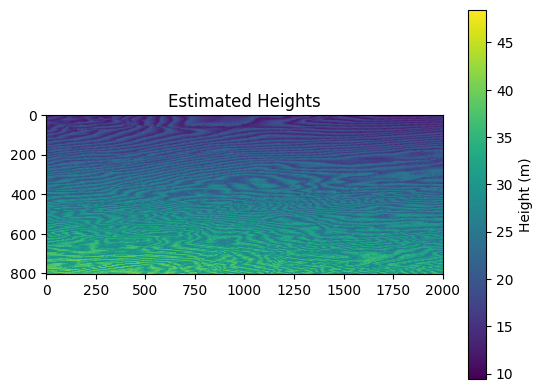

In [9]:
raw_pic(4)

低分图像显示

In [6]:
for i in range(5):
    print(f"pic{i}")
    raw_pic(i)

pic5


IndexError: list index out of range

### 发现如同摩尔纹的噪声


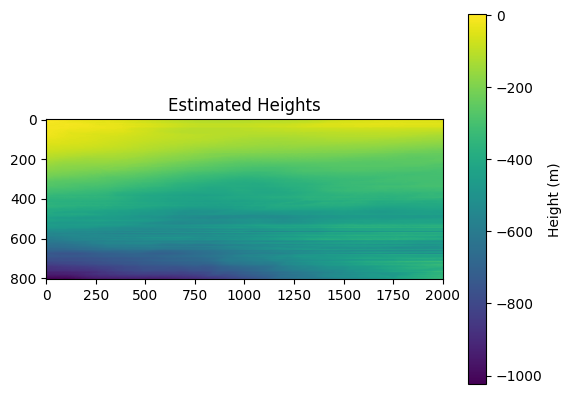

In [2]:


def unwrap_phase(theta):
    # 初始化 phi 矩阵
    phi = np.zeros_like(theta)
    phi[0, 0] = theta[0, 0]
    
    # 展开行
    for i in range(1, theta.shape[0]):
        delta = theta[i, 0] - theta[i-1, 0]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[i, 0] = phi[i-1, 0] + delta_wrapped
    
    # 展开列
    for j in range(1, theta.shape[1]):
        delta = theta[0, j] - theta[0, j-1]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[0, j] = phi[0, j-1] + delta_wrapped
    
    # 展开其余矩阵
    for i in range(1, theta.shape[0]):
        for j in range(1, theta.shape[1]):
            delta_row = theta[i, j] - theta[i-1, j]
            delta_col = theta[i, j] - theta[i, j-1]
            delta_row_wrapped = np.mod(delta_row + np.pi, 2 * np.pi) - np.pi
            delta_col_wrapped = np.mod(delta_col + np.pi, 2 * np.pi) - np.pi
            phi[i, j] = phi[i-1, j] + delta_row_wrapped
            phi[i, j] = phi[i, j-1] + delta_col_wrapped
    
    return phi

theta = np.array(df_theta[4])
# 调用函数进行相位展开
phi = unwrap_phase(theta)

# 输出结果
# print(phi)

results = np.zeros((num_rows, num_cols))

# 遍历每个数据点，计算结果
for i in range(num_rows):
    for j in range(num_cols):
        k_i = df_k[4].iloc[i, j]
        results[i, j] = -1 / k_i * phi[i, j]

# 绘制色度图
plt.imshow(results, cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title('Estimated Heights')
plt.show()

# 绘制色度图
# plt.imshow(unwrapped_phase, cmap='viridis')
# plt.colorbar(label='phi')
# plt.title('phi')
# plt.show()



In [ ]:
from scipy.optimize import least_squares

theta = np.array(df_theta[4])

# 定义代价函数
def cost_function(n, theta):
    # 将 n 转换为矩阵形式
    n_matrix = n.reshape(theta.shape)
    
    # 展开相位
    phi = theta + 2 * np.pi * n_matrix
    
    # 计算相邻元素之间的相位差
    diff_row = np.diff(phi, axis=0)
    diff_col = np.diff(phi, axis=1)
    
    # 计算代价函数的值（相位差的平方和）
    cost = np.sum(diff_row**2) + np.sum(diff_col**2)
    return cost

# 初始 n 猜测（可以设置为全零矩阵）
n_initial = np.zeros_like(theta)

# 将 n_initial 转换为一维数组以适应最小二乘法函数
n_initial_flat = n_initial.flatten()

# 调用最小二乘法函数
res = least_squares(cost_function, n_initial_flat, args=(theta,))

# 从最小二乘解中获取最优 n 值
n_optimal = res.x.reshape(theta.shape)

# 计算最终的展开相位
phi_unwrapped = theta + 2 * np.pi * n_optimal

results = np.zeros((num_rows, num_cols))

# 遍历每个数据点，计算结果
for i in range(num_rows):
    for j in range(num_cols):
        k_i = df_k[4].iloc[i, j]
        results[i, j] = -1 / k_i * phi[i, j]

# 绘制色度图
plt.imshow(results, cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title('Estimated Heights')
plt.show()